
<a id='0'></a> 
# Описание проекта "Predict TripAdvisor Rating".

В рамках данного проекта требуется предсказать рейтинг ресторана в TripAdvisor. Работу над проектом будем проводить по следующим этапам:

1. Импорт библиотек, подготовка функций, чтение и первичный анализ данных:

<a href='#1.1'>1.1. Импорт библиотек, подготовка функций.</a> 

<a href='#1.2'>1.2. Чтение и первичный анализ данных.</a> 

2. Предобработка данных:

<a href='#2.1'>2.1. Обработка признака "cuisine_style".</a> 

<a href='#2.2'>2.2. Обработка признака "price_range".</a> 

<a href='#2.3'>2.3. Обработка признака "number_of_reviews".</a> 

3. Исследовательский анализ данных:

<a href='#3.1'>3.1. Признак "restaurant_id".</a> 

<a href='#3.2'>3.2. Признак "ranking".</a> 

<a href='#3.3'>3.3. Признак "city".</a> 

<a href='#3.4'>3.4. Признак "rating".</a> 

4. Создание новых признаков:

<a href='#4.1'>4.1. Признак "cuisine_style".</a> 

<a href='#4.2'>4.2. Признак "restaurant_id".</a> 

<a href='#4.3'>4.3. Признак "reviews".</a> 

<a href='#4.4'>4.4. Признак "city".</a> 

<a href='#4.5'>4.5. Признаки "ranking" и "number_of_reviews".</a> 

<a href='#4.6'>4.6. Отбор признаков.</a> 

5. Препроцессинг:

<a href='#5.1'>5.1. Написание функции для предобработки данных и создания новых признаков.</a> 

6. Обучение и тестирование модели:

<a href='#6.1'>6.1. Обучение и тестирование модели.</a> 

Метрикой качества модели будет средняя квадратическая ошибка (МАЕ).

# Этап 1. Импорт библиотек, подготовка функций, чтение и первичный анализ данных.

<a id='1.1'></a> 
## Этап 1.1. Импорт библиотек, подготовка функций.

Импортируем нужные для работы библиотеки.

In [1]:
import warnings
warnings.filterwarnings("ignore")
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import os
from datetime import date
from sklearn.preprocessing import StandardScaler
pd.options.display.max_columns = 999

Подготовим несколько функций, которые пригодятся при обработке данных.

In [2]:
def df_info(df):
    print('Первые 10 строк набора данных')
    display(df.head(10))
    print()
    print('Информация о наборе данных:')
    print(df.info())
    print()
    print('Размер набор данных: {} признаков, {} объектов'.format(df.shape[1], df.shape[0]))
    print('Дубликаты:', df.duplicated().sum())
    print('Пропуски:')
    display(df.isna().sum())
    for i in df.columns:
        print(df[i].value_counts())
        
def date_processing(row):
    if row['dates_of_reviews_count'] == 1:
        row['first_review'] = pd.to_datetime(row['dates_of_reviews'][0])
        row['second_review'] = pd.to_datetime(row['dates_of_reviews'][0])
    
    elif row['dates_of_reviews_count'] == 0:
        #добавим 2 идентичные даты, чтобы признак не был пропущенным и чтобы можно было посчитать разницу для других признаков
        row['first_review'] = date(2010, 1, 1)
        row['second_review'] = date(2010, 1, 1)
    
    else:
        if pd.to_datetime(row['dates_of_reviews'][0]) < pd.to_datetime(row['dates_of_reviews'][1]):
            row['first_review'] = pd.to_datetime(row['dates_of_reviews'][1])
            row['second_review'] = pd.to_datetime(row['dates_of_reviews'][0])
        else:
            row['first_review'] = pd.to_datetime(row['dates_of_reviews'][0])
            row['second_review'] = pd.to_datetime(row['dates_of_reviews'][1])
    return row                      

С помощью системной библиотеки os получим директорию, хранящую файлы с данными.

In [3]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
RANDOM_SEED = 42
!pip freeze > requirements.txt

### <a href='#0'>К оглавлению.</a> 

<a id='1.2'></a> 
## Этап 1.2. Чтение и первичный анализ данных.

Считаем данные, используя ранее полученные пути к их местоположению.

In [4]:
data_dir = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(data_dir + '/main_task.csv')
df_test = pd.read_csv(data_dir + 'kaggle_task.csv')
sample_submission = pd.read_csv(data_dir + '/sample_submission.csv')

Для корректной обработки данных соединим тренировочный и тестовый наборы данных в единый набор, при этом тренировочный набор отметим меткой 1, тестовый - меткой 0.

Также в тестовом наборе отсутствует целевая переменная Rating, поэтому в тетсовом наборе данных создадим такой признак и заполним его константой. После обработки данных мы его удалим.

In [5]:
df_train['sample'] = 1
df_test['sample'] = 0
df_test['Rating'] = 0 
df = df_test.append(df_train, sort=False).reset_index(drop=True)

Применим ранее подготовленную функцию для проведения мини-EDA набора данных.

In [6]:
df_info(df)

Первые 10 строк набора данных


,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0
5,id_5,Paris,"['French', 'Cafe', 'Fast Food']",5093.0,$,24.0,"[['Lunch Break', 'Good to Quick Bite'], ['09/0...",/Restaurant_Review-g187147-d8458643-Reviews-Le...,d8458643,0,0.0
6,id_6,Lisbon,"['European', 'Portuguese']",3704.0,$,2.0,"[[], []]",/Restaurant_Review-g189158-d8758873-Reviews-Li...,d8758873,0,0.0
7,id_7,Budapest,NaN,2330.0,NaN,NaN,"[[], []]",/Restaurant_Review-g274887-d8286886-Reviews-Be...,d8286886,0,0.0
8,id_8,Helsinki,"['European', 'Scandinavian']",771.0,NaN,2.0,"[['Big group supper', 'Good food but very slow...",/Restaurant_Review-g189934-d12947542-Reviews-B...,d12947542,0,0.0
9,id_9,Stockholm,['Italian'],605.0,NaN,13.0,"[['Good food', 'Good pizza'], ['12/02/2017', '...",/Restaurant_Review-g189852-d12716384-Reviews-I...,d12716384,0,0.0



Информация о наборе данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB
None

Размер набор данных: 11 признаков, 50000 объектов
Дубликаты: 0
Пропуски:


Restaurant_id            0
City                     0
Cuisine Style        11590
Ranking                  0
Price Range          17361
Number of Reviews     3200
Reviews                  2
URL_TA                   0
ID_TA                    0
sample                   0
Rating                   0
dtype: int64

id_227      19
id_436      19
id_871      19
id_633      19
id_321      18
            ..
id_14321     1
id_11948     1
id_15178     1
id_13681     1
id_15494     1
Name: Restaurant_id, Length: 13094, dtype: int64
London        7193
Paris         6108
Madrid        3813
Barcelona     3395
Berlin        2705
Milan         2694
Rome          2589
Prague        1816
Lisbon        1647
Vienna        1443
Amsterdam     1372
Brussels      1314
Hamburg       1186
Munich        1145
Lyon          1126
Stockholm     1033
Budapest      1021
Warsaw         925
Dublin         836
Copenhagen     819
Athens         776
Edinburgh      745
Zurich         685
Oporto         642
Geneva         590
Krakow         554
Oslo           488
Helsinki       475
Bratislava     380
Luxembourg     263
Ljubljana      222
Name: City, dtype: int64
['Italian']                                                                         1332
['French']                                                                         

Описание признаков:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

Как видим, большинство признаков у нас требует очистки и предварительной обработки.

Для удобства обращения к признакам сведём их к нижнему регистру, а также заменим пробелы на нижние подчёркивания.

In [7]:
df.columns = [str(i).lower().replace(' ', '_') for i in df.columns]

# Вывод по этапу 1.

На данном этапе мы испортировали необходимые для работы библиотеки, подготовили несколько функций для анализа и обработки данных, а также провели мини-EDA набора данных.

### <a href='#0'>К оглавлению.</a> 

# Этап 2. Предобработка данных.

На данном этапе осуществим предварительную обработку данных.

<a id='2.1'></a> 
## Этап 2.1. Признак "cuisine_style".

В признаке cuisine_style представлена информация о кухнях, подаваемых в рестоане.

В данном признаке есть 2 глобальных затруднения:

1. Данные представлены в виде списка, но в форме строки. С такими данными довольно проблематично работать "из коробки".

2. В данных есть пропуски.

Первую проблему решать не будем: как фактор для обучения модели данный признак неинформативен, однако с ним ещё предстоит поработать на этапе создания новых признаков.

Пропущенные значения заменим на наиболее часто встречающуюся кухню в наборе данных.

Чтобы это сделать, сначала выделим из строки каждую отдельную кухню.

In [8]:
top_cuisine = df[['cuisine_style']]
top_cuisine['cuisine_style'] = top_cuisine['cuisine_style'].str.split(',')

Далее с помощью функции explode развернём списки с наименованиями кухонь.

In [9]:
top_cuisine = top_cuisine['cuisine_style'].explode()
top_cuisine

0                         ['Bar'
0                         'Pub']
1                    ['European'
1                 'Scandinavian'
1          'Gluten Free Options'
                  ...           
49998                 'European'
49998         'Eastern European'
49998         'Central European'
49998     'Vegetarian Friendly']
49999                ['Spanish']
Name: cuisine_style, Length: 131266, dtype: object

Видим, что список удалось успешно раскрыть, однако данные содержат много мусора. Их нужно очистить.

In [10]:
top_cuisine = top_cuisine.apply(lambda x: str(x).replace('[', '').replace(']', '').replace("'", "").strip())
top_cuisine

0                        Bar
0                        Pub
1                   European
1               Scandinavian
1        Gluten Free Options
                ...         
49998               European
49998       Eastern European
49998       Central European
49998    Vegetarian Friendly
49999                Spanish
Name: cuisine_style, Length: 131266, dtype: object

Теперь выясним, какая кухня является наиболее часто встречаемой.

In [11]:
top_cuisine = top_cuisine.value_counts(ascending=False).index[0]
top_cuisine

'Vegetarian Friendly'

Видим, что кухня Vegetarian Friendly присутствует в большинстве исследуемых ресторанов. Заменим пропущенные значения признака cuisine_style на значение Vegetarian Friendly.

In [12]:
df['cuisine_style'] = df['cuisine_style'].fillna(top_cuisine)

Посмотрим, что получилось.

In [13]:
df.head()

,restaurant_id,city,cuisine_style,ranking,price_range,number_of_reviews,reviews,url_ta,id_ta,sample,rating
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0


In [14]:
df['cuisine_style'].isna().sum()

0

Пропуски в признаке "cuisine_style" успешно обработаны.

### <a href='#0'>К оглавлению.</a> 

<a id='2.2'></a> 
## Этап 2.2. Признак "price_range".

В признаке price_range также присутствуют пропуски. Их - как и в случае с кухнями - заменим на значение наиболее часто встречающегося значения ценового сегмента ресторана.

In [15]:
df['price_range'].value_counts(ascending=False)

$$ - $$$    23041
$            7816
$$$$         1782
Name: price_range, dtype: int64

Видим, что большинство ресторанов находятся в среднем ценовом сегменте. Заменим пропуски на это значение.

In [16]:
df['price_range'] = df['price_range'].fillna('$$ - $$$')

Так как признак price_range является последовательным, т.е. каждое значение может быть сравнено с другими значениями, имеет смысл закодировать значения признака в числовое представление, с которым сможет работать алгоритм машинного обучения.

Для этого создадим соответствующий словарь, в котором ключ - ценовой сегмент ресторана в старом представлении, а значение - закодированное значение ценового сегмента.

In [17]:
price_dict = {'$' : 1, '$$ - $$$' : 2, '$$$$' : 3}
df['price_range'] = df['price_range'].map(price_dict)

Проверим, что получилось.

In [18]:
df.head()

,restaurant_id,city,cuisine_style,ranking,price_range,number_of_reviews,reviews,url_ta,id_ta,sample,rating
0,id_0,Paris,"['Bar', 'Pub']",12963.0,2,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,2,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,2,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,3,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,3,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0


Признак обработан успешно.

### <a href='#0'>К оглавлению.</a> 

<a id='2.3'></a> 
## Этап 2.3. Признак "number_of_reviews".

В признаке number_of_reviews также присутствуют пропуски.

В данном случае отсутствие значения в признаке, характеризующем количество ревью для определённого ресторана, резонно предположить, что отзывов у ресторана нет. Поэтому пропущенные значения заменяем на 0.

In [19]:
df['number_of_reviews'] = df['number_of_reviews'].fillna(0)

Посмотрим, что получилось.

In [20]:
df['number_of_reviews'].isna().sum()

0

Пропуски успешно обработаны.

### <a href='#0'>К оглавлению.</a> 

# Вывод по этапу 2.

На данном этапе мы осуществили предварительную обработку данных по следующим направлениям:

1. В признаке cuisine_style пропущенные значения заменили на наиболее часто встречающуюся в ресторанах кухню - Vegetarian Friendly.

2. В признаке price_range пропущенные значения заменили на наиболее часто встречающийся ценовой сегмент ресторана в наборе данных, а также закодировали категориальный признак в цифровое представление.

3. В признаке number_of_reviews пропущенные значения заменили на 0.

### <a href='#0'>К оглавлению.</a> 

# Этап 3. Исследовательский анализ данных.

На данном этапе проведём исследовательский анализ данных, чтобы выявить интересные закономерности в данных. 

<a id='3.1'></a> 
## Этап 3.1. Признак "restaurant_id".

Сам по себе признак является бесполезным и не будет участвовать в обучении модели, однако из этапа 1 было видно, что один и тот же ресторан встречается в наборе данных несколько раз.

In [21]:
df['restaurant_id'].value_counts()

id_227      19
id_436      19
id_871      19
id_633      19
id_321      18
            ..
id_14321     1
id_11948     1
id_15178     1
id_13681     1
id_15494     1
Name: restaurant_id, Length: 13094, dtype: int64

Из этого можно предположить, что в наборе данных есть рестораны, представленные в нескольких городах.

In [22]:
df.groupby('restaurant_id')['city'].count()

restaurant_id
id_0       16
id_1       10
id_10      15
id_100     13
id_1000    12
           ..
id_9995     3
id_9996     1
id_9997     1
id_9998     1
id_9999     1
Name: city, Length: 13094, dtype: int64

Так оно и оказалось. Это может стать дополнительным признаком для модели: например, признак примет значение 1, если это сеть ресторанов, и 0, если ресторан только один.

### <a href='#0'>К оглавлению.</a> 

<a id='3.2'></a> 
## Этап 3.2. Признак "ranking".

Исследуем признак ranking.

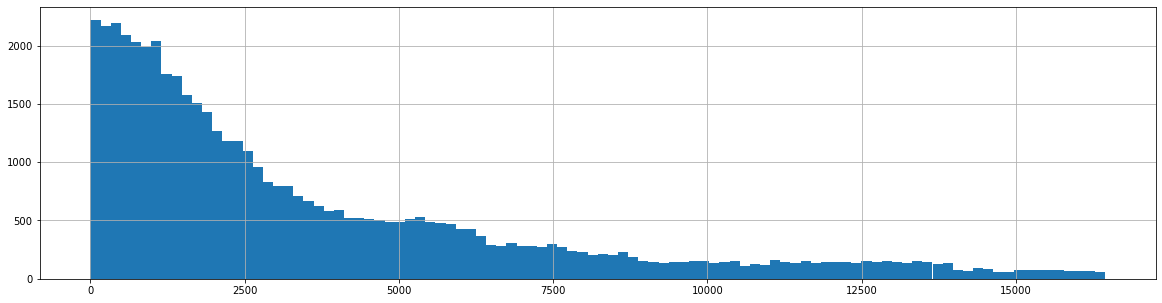

In [23]:
plt.figure(figsize=(20, 5))
df['ranking'].hist(bins=100);

Видим, что распределение данных имеет длинный правый хвост. Это говорит о существенном дисбалансе в значениях признака. Это может быть связано с тем, что в небольших городах присутствует малое количество ресторанов, что оказывает влияние на распределение этого признака. Проверим.

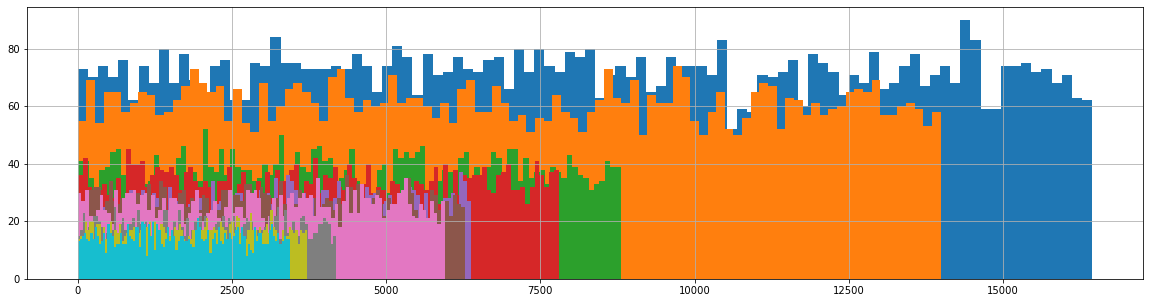

In [24]:
plt.figure(figsize=(20, 5))
for city in (df['city'].value_counts())[:10].index:
    df['ranking'][df['city'] == city].hist(bins=100)
plt.show()

Видим, что распределение стало более однородным, однако границы распределения меняются в зависимости от города. Таким образом, подтверждаем гипотезу о том, что размер города влияет на распределение переменной ranking.

Есть две идеи о нивелировании этого воздействия.

Во-первых, этот признак стоит нормировать через z-преобразование.

Во-вторых, модель корректно учитывала данный признак для стран с разной величиной, его стоит забинить. Однако это осуществим на этапе создания новых признаков.

### <a href='#0'>К оглавлению.</a> 

<a id='3.3'></a> 
## Этап 3.3. Признак "city".

Исследуем признак city. Прежде всего интересует, как количество ресторанов отличается от города к городу.

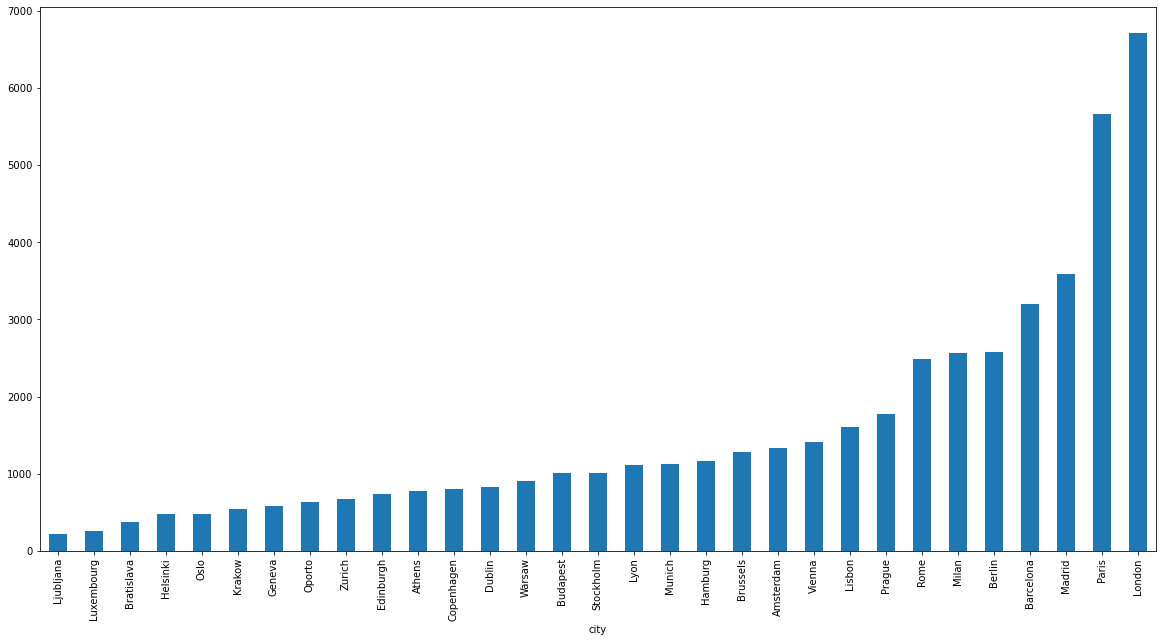

In [25]:
plt.figure(figsize=(20, 10))
df.groupby('city')['restaurant_id'].nunique().sort_values(ascending=True).plot(kind='bar')

Как видим, распределение ресторанов по городам также далеко от нормального. Это объясняет дисбаланс распределения данных в признаке ranking. 

В качестве дополнительных признаков можно сделать дамми-кодирование признака city.

### <a href='#0'>К оглавлению.</a> 

<a id='3.4'></a> 
## Этап 3.4. Признак "rating".

Рассмотрим переменную rating.

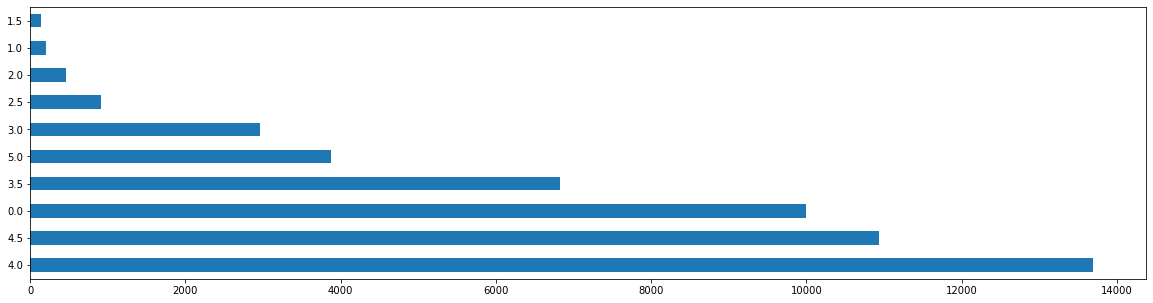

In [26]:
plt.figure(figsize=(20, 5))
df['rating'].value_counts(ascending=False).plot(kind='barh');

Видим, что в наборе данных больше всего собрано информации о ресторанах с высокими оценками (от 3 и выше), и с оценками 0. Может быть, оценка 0 означает, что отзыв мог быть не проставлен. 

Меньше всего отзывов собрано для ресторанов с оценками > 0 и < 3. Вероятно, именно в этих местах модель будет ошибаться чаще.

### <a href='#0'>К оглавлению.</a> 

# Вывод по этапу 3.

На данном этапе мы провели исследовательский анализ данных некоторых имеющихся признаков.

Удалось выяснить, что:

1. В наборе данных встрачаются как одиночные рестораны, так и сети ресторанов.

2. Распределение признака Ranking сильно зависит от размера города и количества в нём ресторанов.

3. В разных городах имеется разное количество уникальных ресторанов.

4. В наборе данных больше всего информации об отзывах с оценкой от 3 и выше, а также с оценкой 0.

### <a href='#0'>К оглавлению.</a> 

# Этап 4. Создание новых признаков.

На данном этапе создадим новые признаки из имеющихся.

<a id='4.1'></a> 
## Этап 4.1. Признак "cuisine_style".

Поработаем с кухнями. 

Для начала создадим признак, который показывает, сколько разных кухонь представлено в ресторане. При этом пропущенные значения мы заменяли на значение Vegetarian Friendly, поэтому в случае наличия толькой такой кухни будем присваивать значение 1. В остальных случаях посчитаем количество кухонь в списке.

In [27]:
df['cuisine_count'] = df['cuisine_style'].apply(lambda x: len(x.split(',')) if x != 'Vegetarian Friendly' else 1)

Также создадим признак, показывающий, есть ли среди кухонь ресторана наиболее популярная - Vegetarian Friendly: если есть, присвоим признаку значение 1, если нет - 0.

In [28]:
df['have_top_cuisine'] = df['cuisine_style'].apply(lambda x: 1 if top_cuisine in x else 0)

Посмотрим, что получилось.

In [29]:
df.head()

,restaurant_id,city,cuisine_style,ranking,price_range,number_of_reviews,reviews,url_ta,id_ta,sample,rating,cuisine_count,have_top_cuisine
0,id_0,Paris,"['Bar', 'Pub']",12963.0,2,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,2,0
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,2,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,5,1
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,2,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,1,1
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,3,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,5,1
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,3,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,6,1


Новый признак успешно создан.

### <a href='#0'>К оглавлению.</a> 

<a id='4.2'></a> 
## Этап 4.2. Признак "restaurant_id".

Ранее мы заметили, что в наборе данных присутствуют как одиночные рестораны, так и сети ресторанов.

Создадим признак, который это покажет: если ресторан уникальный, присвоим значение 0, если сеть - значение 1.

Для начала узнаем, какие рестораны встречаются в наборе данных только 1 раз. Сформируем список таких ресторанов.

In [30]:
unique_restaurants = df['restaurant_id'].value_counts()[df['restaurant_id'].value_counts() == 1].index.to_list()

Далее создадим новый признак: если ресторан присутствует в списке уникальных ресторанов, присваиваем признаку значение 0, в противном случае - значение 1.

In [31]:
df['net_or_unique'] = df['restaurant_id'].apply(lambda x: 0 if x in unique_restaurants else 1)

Посмотрим, что получилось.

In [32]:
df.head()

,restaurant_id,city,cuisine_style,ranking,price_range,number_of_reviews,reviews,url_ta,id_ta,sample,rating,cuisine_count,have_top_cuisine,net_or_unique
0,id_0,Paris,"['Bar', 'Pub']",12963.0,2,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,2,0,1
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,2,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,5,1,1
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,2,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,1,1,1
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,3,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,5,1,1
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,3,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,6,1,1


Новый признак успешно создан.

### <a href='#0'>К оглавлению.</a> 

<a id='4.3'></a> 
## Этап 4.3. Признак "reviews".

Пожалуй, самый необычный признак. Согласно описанию, данный признак содержит даты двух последних ревью. 

Извлечём эти даты с помощью регулярных выражений.

In [33]:
pattern = re.compile("\d+\/\d+\/\d+")
df['dates_of_reviews'] = df['reviews'].apply(lambda x: pattern.findall(str(x)))

Проверим.

In [34]:
df.head()

,restaurant_id,city,cuisine_style,ranking,price_range,number_of_reviews,reviews,url_ta,id_ta,sample,rating,cuisine_count,have_top_cuisine,net_or_unique,dates_of_reviews
0,id_0,Paris,"['Bar', 'Pub']",12963.0,2,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,2,0,1,[]
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,2,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,5,1,1,"[12/05/2017, 10/29/2017]"
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,2,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,1,1,1,"[12/28/2017, 12/06/2017]"
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,3,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,5,1,1,"[12/06/2017, 11/22/2017]"
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,3,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,6,1,1,"[02/08/2018, 01/24/2018]"


Мы получили список, содержащий даты последних ревью. Однако на текущий момент эти даты представлены в виде строки. Чтобы с ними было удобно работать, преобразуем их в формат datetime.

In [35]:
df['dates_of_reviews'] = df['dates_of_reviews'].apply(lambda x: [pd.to_datetime(i).date() for i in x])

Модно заметить, что иногда в отзыве нет даты, иногда она одна. Стоит добавить признак, который покажет, сколько у нас имеется датированных отзывов.

In [36]:
df['dates_of_reviews_count'] = df['dates_of_reviews'].apply(lambda x: len(x))

Посмотрим на распределение признака.

In [37]:
df['dates_of_reviews_count'].value_counts()

2    36202
0     8114
1     5680
3        4
Name: dates_of_reviews_count, dtype: int64

Чаще всего встречается ситуация с двумя датированными отзывами. А вот наличие трёх датированных отзывов уже не стыкуется с описанием данных. Жить не мешает, но всё же посмотрим на них.

In [38]:
df[df['dates_of_reviews_count'] == 3]

,restaurant_id,city,cuisine_style,ranking,price_range,number_of_reviews,reviews,url_ta,id_ta,sample,rating,cuisine_count,have_top_cuisine,net_or_unique,dates_of_reviews,dates_of_reviews_count
2221,id_2221,London,"['Lebanese', 'Fast Food', 'Mediterranean', 'Tu...",3552.0,1,202.0,"[['We visited 21/10/17', 'Best Kebab in London...",/Restaurant_Review-g186338-d1009460-Reviews-Ta...,d1009460,0,0.0,6,0,1,"[2017-10-21, 2017-12-22, 2017-10-19]",3
3809,id_3809,Stockholm,"['European', 'Swedish', 'Scandinavian']",956.0,2,9.0,"[['Good Museum Cafeteria', 'Lunch 30/5/2017'],...",/Restaurant_Review-g189852-d12318961-Reviews-N...,d12318961,0,0.0,3,0,1,"[2017-05-30, 2017-04-13, 2017-05-30]",3
19254,id_12965,London,"['Cafe', 'French']",12975.0,2,31.0,"[['The desserts arcade !', 'Visit today 3/1/20...",/Restaurant_Review-g186338-d1017372-Reviews-Ma...,d1017372,1,3.5,2,0,1,"[2017-03-01, 2017-06-02, 2017-01-03]",3
33348,id_450,Geneva,"['French', 'European']",453.0,2,48.0,"[['lunch 29/9/2016', 'Unplanned Great Dinner']...",/Restaurant_Review-g188057-d2706773-Reviews-Le...,d2706773,1,4.0,2,0,1,"[2016-09-29, 2016-09-30, 2016-08-25]",3


Как видим, третий отзыв всегда не является свежее двух предыдущих, что нам на руку.

Будет полезно создать признаки с первым и вторым отзывом, чтобы сравнить их между собой. При этом важно учесть, что порядок нахождения отзыва в списке не говорит о том, какой отзыв был оставлен раньше, а какой позже. Поэтому даты придётся ещё и сравнивать. Для этого воспользуемся подготовленной функцией date_processing. Она учитывает наличие и только одного отзыва, и отсутствие отзыва в принципе, и наличие трёх отзывов.

In [39]:
df = df.apply(date_processing, axis=1)

Проверим, что получилось.

In [40]:
df.head()

,restaurant_id,city,cuisine_style,ranking,price_range,number_of_reviews,reviews,url_ta,id_ta,sample,rating,cuisine_count,have_top_cuisine,net_or_unique,dates_of_reviews,dates_of_reviews_count,first_review,second_review
0,id_0,Paris,"['Bar', 'Pub']",12963.0,2,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,2,0,1,[],0,2010-01-01,2010-01-01
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,2,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,5,1,1,"[2017-12-05, 2017-10-29]",2,2017-12-05,2017-10-29
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,2,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,1,1,1,"[2017-12-28, 2017-12-06]",2,2017-12-28,2017-12-06
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,3,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,5,1,1,"[2017-12-06, 2017-11-22]",2,2017-12-06,2017-11-22
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,3,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,6,1,1,"[2018-02-08, 2018-01-24]",2,2018-02-08,2018-01-24


Даты успешно обработали. Теперь можно посчитать разницу в днях между первым и вторым отзывами.

In [41]:
df['review_timedelta'] = (pd.to_datetime(df['first_review']) - pd.to_datetime(df['second_review'])).dt.days

Посмотрим, как распределён признак.

In [42]:
df['review_timedelta'].value_counts().sort_values()

943         1
1561        1
1526        1
885         1
853         1
        ...  
4         538
3         606
2         629
1         830
0       14425
Name: review_timedelta, Length: 1310, dtype: int64

Видим, что в признаке есть как небольшие разбежки, так и неадекватно большие. Последние, вероятно, возникли из-за неправильного ввода данных. Удалять их необязательно, но и оставить тоже не хотелось бы. Решение - применить биннинг. Количество групп - 10 - было подобрано эмпирически.

In [43]:
df['review_timedelta'] = pd.cut(df['review_timedelta'], 10)

Проверим, что получилось.

In [44]:
df.head()

,restaurant_id,city,cuisine_style,ranking,price_range,number_of_reviews,reviews,url_ta,id_ta,sample,rating,cuisine_count,have_top_cuisine,net_or_unique,dates_of_reviews,dates_of_reviews_count,first_review,second_review,review_timedelta
0,id_0,Paris,"['Bar', 'Pub']",12963.0,2,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,2,0,1,[],0,2010-01-01,2010-01-01,"(-3.296, 329.6]"
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,2,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,5,1,1,"[2017-12-05, 2017-10-29]",2,2017-12-05,2017-10-29,"(-3.296, 329.6]"
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,2,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,1,1,1,"[2017-12-28, 2017-12-06]",2,2017-12-28,2017-12-06,"(-3.296, 329.6]"
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,3,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,5,1,1,"[2017-12-06, 2017-11-22]",2,2017-12-06,2017-11-22,"(-3.296, 329.6]"
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,3,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,6,1,1,"[2018-02-08, 2018-01-24]",2,2018-02-08,2018-01-24,"(-3.296, 329.6]"


Биннинг провели, однако в таком виде их в модель не передашь. Нужно закодировать. Для этого создадим словарь и с его помощью осуществим кодировку.

In [45]:
interval_dict = df['review_timedelta'].value_counts().to_dict()
interval_dict

{Interval(-3.296, 329.6, closed='right'): 46046,
 Interval(329.6, 659.2, closed='right'): 2784,
 Interval(659.2, 988.8, closed='right'): 669,
 Interval(988.8, 1318.4, closed='right'): 287,
 Interval(1318.4, 1648.0, closed='right'): 121,
 Interval(1648.0, 1977.6, closed='right'): 52,
 Interval(1977.6, 2307.2, closed='right'): 15,
 Interval(2966.4, 3296.0, closed='right'): 9,
 Interval(2307.2, 2636.8, closed='right'): 9,
 Interval(2636.8, 2966.4, closed='right'): 8}

Пока не очень похоже на то, что нужно: словарь есть, но его значения совсем не подходят под наши потребности. Немного исправим словарь с помощью цикла.

In [46]:
for i, j in enumerate(interval_dict):
    interval_dict[j] = i
interval_dict

{Interval(-3.296, 329.6, closed='right'): 0,
 Interval(329.6, 659.2, closed='right'): 1,
 Interval(659.2, 988.8, closed='right'): 2,
 Interval(988.8, 1318.4, closed='right'): 3,
 Interval(1318.4, 1648.0, closed='right'): 4,
 Interval(1648.0, 1977.6, closed='right'): 5,
 Interval(1977.6, 2307.2, closed='right'): 6,
 Interval(2966.4, 3296.0, closed='right'): 7,
 Interval(2307.2, 2636.8, closed='right'): 8,
 Interval(2636.8, 2966.4, closed='right'): 9}

Гораздо лучше. Можно осуществлять кодировку.

In [47]:
df['review_timedelta'] = df['review_timedelta'].map(interval_dict)

Также у нас появились признаки-даты, из которых до кучи можно извлечь пару-тройку признаков: день, месяц, год и день недели отзыва.

In [48]:
df['day_first_review'] = df['first_review'].dt.day
df['month_first_review'] = df['first_review'].dt.month
df['year_first_review'] = df['first_review'].dt.year
df['day_of_week_first_review'] = df['first_review'].dt.dayofweek
df['day_second_review'] = df['second_review'].dt.day
df['month_second_review'] = df['second_review'].dt.month
df['year_second_review'] = df['second_review'].dt.year
df['day_of_week_second_review'] = df['second_review'].dt.dayofweek

Проверим, что получилось.

In [49]:
df.head()

,restaurant_id,city,cuisine_style,ranking,price_range,number_of_reviews,reviews,url_ta,id_ta,sample,rating,cuisine_count,have_top_cuisine,net_or_unique,dates_of_reviews,dates_of_reviews_count,first_review,second_review,review_timedelta,day_first_review,month_first_review,year_first_review,day_of_week_first_review,day_second_review,month_second_review,year_second_review,day_of_week_second_review
0,id_0,Paris,"['Bar', 'Pub']",12963.0,2,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,2,0,1,[],0,2010-01-01,2010-01-01,0,1,1,2010,4,1,1,2010,4
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,2,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,5,1,1,"[2017-12-05, 2017-10-29]",2,2017-12-05,2017-10-29,0,5,12,2017,1,29,10,2017,6
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,2,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,1,1,1,"[2017-12-28, 2017-12-06]",2,2017-12-28,2017-12-06,0,28,12,2017,3,6,12,2017,2
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,3,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,5,1,1,"[2017-12-06, 2017-11-22]",2,2017-12-06,2017-11-22,0,6,12,2017,2,22,11,2017,2
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,3,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,6,1,1,"[2018-02-08, 2018-01-24]",2,2018-02-08,2018-01-24,0,8,2,2018,3,24,1,2018,2


Видим, что мы успешно создали ряд новых признаков на основе дат первого и второго ревью.

### <a href='#0'>К оглавлению.</a> 

<a id='4.4'></a> 
## Этап 4.4. Признак "city".

Поработаем с признаком city. Ранее мы выяснили, что количество ресторанов в городе может быть различным. Сделаем для каждого города признак, описывающий количество уникальных ресторанов для этого города.

In [50]:
restaurants_count_dict = df.groupby('city')['restaurant_id'].nunique().to_dict()
df['restaurants_in_city_count'] = df['city'].map(restaurants_count_dict)

Далее из данного признака сделаем дамми-переменные, при этом - чтобы не попасть в ловушку дамми-переменных из-за эффекта мультиколлинеарности - исключим из спектра дамми-переменных одно значение признака. То есть при n-городов у нас останется n-1 дамми-признак. Зная n-1 значений соответствующих дамми-признаков, без труда можно восстановить последний дамми-признак.

In [51]:
df = pd.get_dummies(data=df, columns=['city'], drop_first=True)

Проверим.

In [52]:
df.head()

,restaurant_id,cuisine_style,ranking,price_range,number_of_reviews,reviews,url_ta,id_ta,sample,rating,cuisine_count,have_top_cuisine,net_or_unique,dates_of_reviews,dates_of_reviews_count,first_review,second_review,review_timedelta,day_first_review,month_first_review,year_first_review,day_of_week_first_review,day_second_review,month_second_review,year_second_review,day_of_week_second_review,restaurants_in_city_count,city_Athens,city_Barcelona,city_Berlin,city_Bratislava,city_Brussels,city_Budapest,city_Copenhagen,city_Dublin,city_Edinburgh,city_Geneva,city_Hamburg,city_Helsinki,city_Krakow,city_Lisbon,city_Ljubljana,city_London,city_Luxembourg,city_Lyon,city_Madrid,city_Milan,city_Munich,city_Oporto,city_Oslo,city_Paris,city_Prague,city_Rome,city_Stockholm,city_Vienna,city_Warsaw,city_Zurich
0,id_0,"['Bar', 'Pub']",12963.0,2,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,2,0,1,[],0,2010-01-01,2010-01-01,0,1,1,2010,4,1,1,2010,4,5660,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,id_1,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,2,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,5,1,1,"[2017-12-05, 2017-10-29]",2,2017-12-05,2017-10-29,0,5,12,2017,1,29,10,2017,6,472,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,id_2,['Vegetarian Friendly'],810.0,2,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,1,1,1,"[2017-12-28, 2017-12-06]",2,2017-12-28,2017-12-06,0,28,12,2017,3,6,12,2017,2,733,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,id_3,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,3,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,5,1,1,"[2017-12-06, 2017-11-22]",2,2017-12-06,2017-11-22,0,6,12,2017,2,22,11,2017,2,6713,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,id_4,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,3,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,6,1,1,"[2018-02-08, 2018-01-24]",2,2018-02-08,2018-01-24,0,8,2,2018,3,24,1,2018,2,378,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Дамми-признаки на основе признака "city" успешно созданы.

### <a href='#0'>К оглавлению.</a> 

<a id='4.5'></a> 
## Этап 4.5. Признаки "ranking" и "number_of_reviews".

Поработаем с признаками ranking и number_of_reviews.

Ранее мы говорили о необходимости стандартизации значений признака ranking и применения к нему биннинга. Стандартизировать можно также и признак number_of_reviews.

Начнём с биннинга. Процедуру уже делали с признаком review_timedelta, делаем то же самое.

In [53]:
df['ranking_bins'] = pd.cut(df['ranking'], 10)

Посмотрим, что получилось.

In [54]:
df.head()

,restaurant_id,cuisine_style,ranking,price_range,number_of_reviews,reviews,url_ta,id_ta,sample,rating,cuisine_count,have_top_cuisine,net_or_unique,dates_of_reviews,dates_of_reviews_count,first_review,second_review,review_timedelta,day_first_review,month_first_review,year_first_review,day_of_week_first_review,day_second_review,month_second_review,year_second_review,day_of_week_second_review,restaurants_in_city_count,city_Athens,city_Barcelona,city_Berlin,city_Bratislava,city_Brussels,city_Budapest,city_Copenhagen,city_Dublin,city_Edinburgh,city_Geneva,city_Hamburg,city_Helsinki,city_Krakow,city_Lisbon,city_Ljubljana,city_London,city_Luxembourg,city_Lyon,city_Madrid,city_Milan,city_Munich,city_Oporto,city_Oslo,city_Paris,city_Prague,city_Rome,city_Stockholm,city_Vienna,city_Warsaw,city_Zurich,ranking_bins
0,id_0,"['Bar', 'Pub']",12963.0,2,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,2,0,1,[],0,2010-01-01,2010-01-01,0,1,1,2010,4,1,1,2010,4,5660,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,"(11511.1, 13155.4]"
1,id_1,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,2,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,5,1,1,"[2017-12-05, 2017-10-29]",2,2017-12-05,2017-10-29,0,5,12,2017,1,29,10,2017,6,472,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"(-15.443, 1645.3]"
2,id_2,['Vegetarian Friendly'],810.0,2,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,1,1,1,"[2017-12-28, 2017-12-06]",2,2017-12-28,2017-12-06,0,28,12,2017,3,6,12,2017,2,733,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"(-15.443, 1645.3]"
3,id_3,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,3,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,5,1,1,"[2017-12-06, 2017-11-22]",2,2017-12-06,2017-11-22,0,6,12,2017,2,22,11,2017,2,6713,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"(1645.3, 3289.6]"
4,id_4,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,3,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,6,1,1,"[2018-02-08, 2018-01-24]",2,2018-02-08,2018-01-24,0,8,2,2018,3,24,1,2018,2,378,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"(-15.443, 1645.3]"


Далее кодируем значение нового признака.

In [55]:
ranking_bins_dict = df['ranking_bins'].value_counts().to_dict()
ranking_bins_dict

{Interval(-15.443, 1645.3, closed='right'): 19802,
 Interval(1645.3, 3289.6, closed='right'): 11046,
 Interval(3289.6, 4933.9, closed='right'): 5719,
 Interval(4933.9, 6578.2, closed='right'): 4475,
 Interval(6578.2, 8222.5, closed='right'): 2676,
 Interval(8222.5, 9866.8, closed='right'): 1700,
 Interval(11511.1, 13155.4, closed='right'): 1435,
 Interval(9866.8, 11511.1, closed='right'): 1381,
 Interval(13155.4, 14799.7, closed='right'): 1075,
 Interval(14799.7, 16444.0, closed='right'): 691}

In [56]:
for i, j in enumerate(ranking_bins_dict):
    ranking_bins_dict[j] = i
ranking_bins_dict

{Interval(-15.443, 1645.3, closed='right'): 0,
 Interval(1645.3, 3289.6, closed='right'): 1,
 Interval(3289.6, 4933.9, closed='right'): 2,
 Interval(4933.9, 6578.2, closed='right'): 3,
 Interval(6578.2, 8222.5, closed='right'): 4,
 Interval(8222.5, 9866.8, closed='right'): 5,
 Interval(11511.1, 13155.4, closed='right'): 6,
 Interval(9866.8, 11511.1, closed='right'): 7,
 Interval(13155.4, 14799.7, closed='right'): 8,
 Interval(14799.7, 16444.0, closed='right'): 9}

Кодируем.

In [57]:
df['ranking_bins'] = df['ranking_bins'].map(ranking_bins_dict)

Далее осуществим z-стандартизацию. Будем использовать соответствующий инструмент из библиотеки sklearn. Для чистоты эксперимента обучать инструмент будем только на обучающей выборке, и на её основе трансформировать тестовую выборку.

Для начала разделим их.

In [58]:
train = df[df['sample'] == 1]
test = df[df['sample'] == 0]

Создадим объект инструмента шкалирования и обучим его на признаках "ranking" и "number_of_reviews" из обучающей выборки.

In [59]:
scaler = StandardScaler()
scaler.fit(train[['ranking', 'number_of_reviews']])

StandardScaler()

Инструмент обучен. Применим его к данным - для обоих выборок, так как мы только обучили инструмент, но не преобразовывали обучающую выборку.

In [60]:
train[['ranking', 'number_of_reviews']] = scaler.transform(train[['ranking', 'number_of_reviews']])
test[['ranking', 'number_of_reviews']] = scaler.transform(test[['ranking', 'number_of_reviews']])

Соединим наши выборки.

In [61]:
df = test.append(train, sort=False).reset_index(drop=True) # объединяем

Посмотрим на результат.

In [62]:
df.head()

,restaurant_id,cuisine_style,ranking,price_range,number_of_reviews,reviews,url_ta,id_ta,sample,rating,cuisine_count,have_top_cuisine,net_or_unique,dates_of_reviews,dates_of_reviews_count,first_review,second_review,review_timedelta,day_first_review,month_first_review,year_first_review,day_of_week_first_review,day_second_review,month_second_review,year_second_review,day_of_week_second_review,restaurants_in_city_count,city_Athens,city_Barcelona,city_Berlin,city_Bratislava,city_Brussels,city_Budapest,city_Copenhagen,city_Dublin,city_Edinburgh,city_Geneva,city_Hamburg,city_Helsinki,city_Krakow,city_Lisbon,city_Ljubljana,city_London,city_Luxembourg,city_Lyon,city_Madrid,city_Milan,city_Munich,city_Oporto,city_Oslo,city_Paris,city_Prague,city_Rome,city_Stockholm,city_Vienna,city_Warsaw,city_Zurich,ranking_bins
0,id_0,"['Bar', 'Pub']",2.504102,2,-0.392351,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,2,0,1,[],0,2010-01-01,2010-01-01,0,1,1,2010,4,1,1,2010,4,5660,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,6
1,id_1,"['European', 'Scandinavian', 'Gluten Free Opti...",-0.962608,2,-0.069127,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,5,1,1,"[2017-12-05, 2017-10-29]",2,2017-12-05,2017-10-29,0,5,12,2017,1,29,10,2017,6,472,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,id_2,['Vegetarian Friendly'],-0.772785,2,-0.308938,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,1,1,1,"[2017-12-28, 2017-12-06]",2,2017-12-28,2017-12-06,0,28,12,2017,3,6,12,2017,2,733,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,id_3,"['Italian', 'Mediterranean', 'European', 'Vege...",-0.541167,3,0.295803,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,5,1,1,"[2017-12-06, 2017-11-22]",2,2017-12-06,2017-11-22,0,6,12,2017,2,22,11,2017,2,6713,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,id_4,"['Italian', 'Mediterranean', 'European', 'Seaf...",-0.981213,3,0.156782,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,6,1,1,"[2018-02-08, 2018-01-24]",2,2018-02-08,2018-01-24,0,8,2,2018,3,24,1,2018,2,378,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Трансформация данных прошла хорошо.

### <a href='#0'>К оглавлению.</a> 

<a id='4.6'></a> 
## Этап 4.6. Отбор признаков.

Мы создали несколько новых признаков.

Избавимся от лишних признаков, которые не будут участвовать в обучении модели.

In [63]:
df.drop(['restaurant_id', 'reviews', 'url_ta', 'id_ta', 'cuisine_style', 'dates_of_reviews', 'first_review', 
         'second_review'], axis=1, inplace=True)

Посмотрим на корреляционную матрицу и избавимся от скоррелированных признаков.

,ranking,price_range,number_of_reviews,rating,cuisine_count,have_top_cuisine,net_or_unique,dates_of_reviews_count,day_first_review,month_first_review,year_first_review,day_of_week_first_review,day_second_review,month_second_review,year_second_review,day_of_week_second_review,restaurants_in_city_count,city_Athens,city_Barcelona,city_Berlin,city_Bratislava,city_Brussels,city_Budapest,city_Copenhagen,city_Dublin,city_Edinburgh,city_Geneva,city_Hamburg,city_Helsinki,city_Krakow,city_Lisbon,city_Ljubljana,city_London,city_Luxembourg,city_Lyon,city_Madrid,city_Milan,city_Munich,city_Oporto,city_Oslo,city_Paris,city_Prague,city_Rome,city_Stockholm,city_Vienna,city_Warsaw,city_Zurich
ranking,1.000000,-0.026334,-0.223198,-0.109897,-0.322408,-0.142216,-0.502592,-0.140930,-0.033270,-0.036776,-0.166208,0.022426,-0.046645,-0.111151,-0.174823,0.012211,0.709015,-0.094479,0.015683,-0.026436,-0.075731,-0.094241,-0.095421,-0.093549,-0.094884,-0.092380,-0.087158,-0.096430,-0.082057,-0.087200,-0.089639,-0.061906,0.499127,-0.065961,-0.096835,0.056229,-0.036015,-0.094920,-0.089770,-0.083496,0.330099,-0.082766,-0.043811,-0.095269,-0.090999,-0.096816,-0.091422
price_range,-0.026334,1.000000,0.107732,-0.012176,0.002816,0.148078,0.005652,-0.073869,-0.044148,-0.056009,-0.075862,0.020321,-0.047356,-0.032464,-0.073511,0.021667,0.004256,-0.023953,-0.014778,-0.009564,0.011952,0.011153,-0.024773,0.016773,-0.012263,-0.032960,0.040105,0.022506,0.007501,-0.029098,-0.025073,-0.009434,-0.016906,0.018210,0.023647,0.025075,-0.019115,0.023548,-0.028902,0.018785,0.042213,-0.017982,-0.050266,0.030934,0.014506,0.002336,0.028459
number_of_reviews,-0.223198,0.107732,1.000000,0.011006,0.409446,0.158894,0.061956,0.214637,0.027465,0.002168,0.234508,-0.034887,0.056628,0.109087,0.243587,-0.022639,0.026764,-0.012802,0.009418,-0.049192,-0.022211,-0.017096,0.014535,-0.011974,0.013848,0.049210,-0.022437,-0.041022,-0.018609,0.002064,0.001748,-0.007984,0.019068,-0.009492,-0.017538,-0.022922,0.036367,-0.023834,0.003451,-0.007289,-0.006570,-0.004370,0.134553,-0.023958,-0.025635,-0.027038,-0.019863
rating,-0.109897,-0.012176,0.011006,1.000000,0.034506,0.024434,0.150831,0.008114,-0.002510,0.000185,0.020564,-0.003508,0.000880,0.015913,0.024387,-0.002794,-0.014702,0.016852,-0.000703,0.012834,-0.002550,-0.003957,0.006301,0.000948,0.005758,0.005484,0.002312,0.002112,-0.004032,0.007538,-0.000081,0.007644,-0.006952,-0.002940,-0.005922,-0.016232,-0.023233,-0.003420,0.009654,-0.007143,-0.007362,0.001123,0.027527,-0.010417,0.010188,0.001580,-0.001481
cuisine_count,-0.322408,0.002816,0.409446,0.034506,1.000000,0.208239,0.092590,0.373177,0.100596,0.165648,0.380502,-0.048151,0.135148,0.262986,0.402328,-0.044256,-0.023536,-0.000820,0.007978,-0.045732,-0.019017,-0.011082,0.051676,0.005689,0.049619,0.074769,-0.001517,-0.058841,0.000110,0.029809,0.003139,0.028561,0.077268,0.004630,-0.082263,-0.081689,-0.019310,-0.013927,0.005994,0.025078,-0.098858,0.024347,0.072942,-0.009093,0.011112,-0.004428,0.024870
have_top_cuisine,-0.142216,0.148078,0.158894,0.024434,0.208239,1.000000,0.053258,0.012056,-0.014581,-0.000866,0.054521,-0.001957,-0.001958,0.067326,0.070824,0.007223,-0.011926,-0.019902,-0.009859,0.046774,-0.005364,-0.018274,-0.007066,-0.001106,0.008982,0.029194,-0.003042,0.039836,-0.000126,0.005439,-0.025921,-0.013067,0.035526,-0.007033,-0.024746,-0.022477,0.010115,0.035712,-0.015938,-0.003241,-0.063859,-0.059925,0.028145,0.013186,0.019327,0.001543,0.023107
net_or_unique,-0.502592,0.005652,0.061956,0.150831,0.092590,0.053258,1.000000,-0.020237,-0.020108,-0.022411,-0.003962,0.009247,-0.022881,0.004418,0.000800,0.007531,-0.309220,0.022624,0.052005,0.046988,0.019045,0.031606,0.024387,0.024571,0.026261,0.026593,0.016706,0.033351,0.023451,0.021743,0.031013,0.016903,-0.293154,0.018791,0.032393,0.054358,0.050473,0.029834,0.025373,0.019296,-0.127558,0.037594,0.047007,0.027383,0.033274,0.029340,0.027347
dates_of_reviews_count,-0.140930,-0.073869,0.214637,0.008114,0.373177,0.012056,-0.020237,1.000000,0.470956,0.

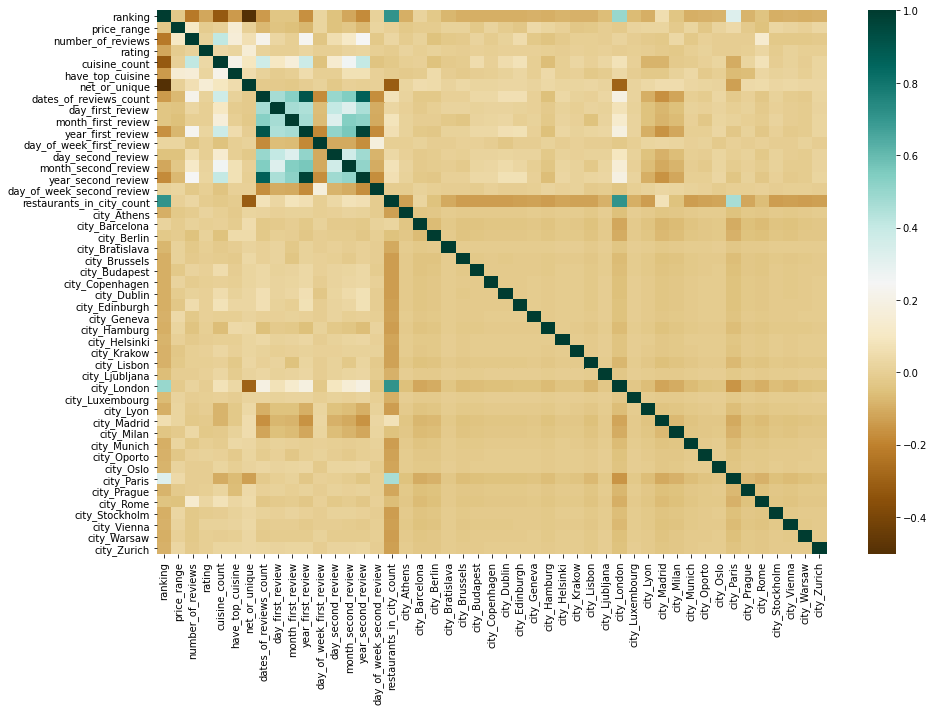

In [64]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(df.drop(['sample'], axis=1).corr(),cmap="BrBG")
df.drop(['sample'], axis=1).corr()

Как видим, в наборе данных нет сильно скоррелированных с целевой переменной признаков, эффект мультиколлинеарности также не наблюдается.

### <a href='#0'>К оглавлению.</a> 

# Вывод по этапу 4.

На данном этапе мы создали новые признаки на основе уже имеющихся в наборе данных:

1. На основе признака "cuisine_style" мы создали признак, показывающий количество кухонь, представленных в ресторане, а также признак наличия в ресторане самой популярной кухни.

2. На основе признака "restaurant_id" мы создали признак, показывающий, чем является ресторан - уникальные заведением или сетью ресторанов.

3. На основе признака "reviews" мы создали два промежуточных параметра - дата первого и второго доступных ревью - и на их основе создали ряд новых признаков: разницу в днях между ревью, а также признаки-даты из этих двух дат: год, месяц, день и день недели первого и второго ревью.

4. С помощью признаков "city" и "restaurant_id" мы создали признак, описывающий количество уникальных ресторанов в каждом городе, а также дамми-переменные на основе признака "city", при этом для избежания эффекта мультиколлиреарности мы построили n-1 дамми-признак, где n - количество уникальных городов в наборе данных.

5. На основе признака "ranking" была создана переменная, разбивающая признак "ranking" на 10 групп по мере возрастания значения признака. Кроме того, признаки "ranking" и "number_of_reviews" были нормированы с помощью z-преобразования.

6. На последнем этапе мы избавились от ненужных для моделирования признаков, а также проверили признаки с помощью корреляционной матрицы на предмет сильной скоррелированности признаков с целеовой переменной и мультиколлинеарности.

### <a href='#0'>К оглавлению.</a> 

# Этап 5. Препроцессинг.

<a id='5.1'></a> 
## Этап 5.1. Написание функции для предобработки данных и создания новых признаков.

На данном этапе проделанные выше этапы предобработки данных и создания новых признаков обернём в единую функцию.

Для начала заново создадим исходный набор данных.

In [65]:
data_dir = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(data_dir + '/main_task.csv')
df_test = pd.read_csv(data_dir + 'kaggle_task.csv')
sample_submission = pd.read_csv(data_dir + '/sample_submission.csv')

df_train['sample'] = 1
df_test['sample'] = 0
df_test['Rating'] = 0 
df = df_test.append(df_train, sort=False).reset_index(drop=True)

Напишем функцию.

In [66]:
def data_preprocessing(df):
    
    df.columns = [str(i).lower().replace(' ', '_') for i in df.columns]
    
    top_cuisine = df[['cuisine_style']]
    top_cuisine['cuisine_style'] = top_cuisine['cuisine_style'].str.split(',')
    top_cuisine = top_cuisine['cuisine_style'].explode()
    top_cuisine = top_cuisine.apply(lambda x: str(x).replace('[', '').replace(']', '').replace("'", "").strip())
    top_cuisine = top_cuisine.value_counts(ascending=False).index[0]
    df['cuisine_style'] = df['cuisine_style'].fillna(top_cuisine)
    
    df['price_range'] = df['price_range'].fillna('$$ - $$$')
    price_dict = {'$' : 1, '$$ - $$$' : 2, '$$$$' : 3}
    df['price_range'] = df['price_range'].map(price_dict)
    
    df['number_of_reviews'] = df['number_of_reviews'].fillna(0)
    
    df['cuisine_count'] = df['cuisine_style'].apply(lambda x: len(x.split(',')) if x != 'Vegetarian Friendly' else 1)
    
    df['have_top_cuisine'] = df['cuisine_style'].apply(lambda x: 1 if top_cuisine in x else 0)
    
    unique_restaurants = df['restaurant_id'].value_counts()[df['restaurant_id'].value_counts() == 1].index.to_list()
    df['net_or_unique'] = df['restaurant_id'].apply(lambda x: 0 if x in unique_restaurants else 1)
    
    pattern = re.compile("\d+\/\d+\/\d+")
    df['dates_of_reviews'] = df['reviews'].apply(lambda x: pattern.findall(str(x)))
    df['dates_of_reviews'] = df['dates_of_reviews'].apply(lambda x: [pd.to_datetime(i).date() for i in x])
    df['dates_of_reviews_count'] = df['dates_of_reviews'].apply(lambda x: len(x))
    df = df.apply(date_processing, axis=1)
    df['review_timedelta'] = (pd.to_datetime(df['first_review']) - pd.to_datetime(df['second_review'])).dt.days
    df['review_timedelta'] = pd.cut(df['review_timedelta'], 10)
    interval_dict = df['review_timedelta'].value_counts().to_dict()
    for i, j in enumerate(interval_dict):
        interval_dict[j] = i
    df['review_timedelta'] = df['review_timedelta'].map(interval_dict)
    df['day_first_review'] = df['first_review'].dt.day
    df['month_first_review'] = df['first_review'].dt.month
    df['year_first_review'] = df['first_review'].dt.year
    df['day_of_week_first_review'] = df['first_review'].dt.dayofweek
    df['day_second_review'] = df['second_review'].dt.day
    df['month_second_review'] = df['second_review'].dt.month
    df['year_second_review'] = df['second_review'].dt.year
    df['day_of_week_second_review'] = df['second_review'].dt.dayofweek
    
    restaurants_count_dict = df.groupby('city')['restaurant_id'].nunique().to_dict()
    df['restaurants_in_city_count'] = df['city'].map(restaurants_count_dict)
    
    df = pd.get_dummies(data=df, columns=['city'], drop_first=True)
    df['ranking_bins'] = pd.cut(df['ranking'], 10)
    
    ranking_bins_dict = df['ranking_bins'].value_counts().to_dict()
    for i, j in enumerate(ranking_bins_dict):
        ranking_bins_dict[j] = i
    df['ranking_bins'] = df['ranking_bins'].map(ranking_bins_dict)
    
    train = df[df['sample'] == 1]
    test = df[df['sample'] == 0]
    
    scaler = StandardScaler()
    scaler.fit(train[['ranking', 'number_of_reviews']])
    train[['ranking', 'number_of_reviews']] = scaler.transform(train[['ranking', 'number_of_reviews']])
    test[['ranking', 'number_of_reviews']] = scaler.transform(test[['ranking', 'number_of_reviews']])
    
    df = test.append(train, sort=False).reset_index(drop=True)
    df.drop(['restaurant_id', 'reviews', 'url_ta', 'id_ta', 'cuisine_style', 'dates_of_reviews', 'first_review', 
             'second_review'], axis=1, inplace=True)
    
    return df

Функция написана. Применим её к нашему набору данных.

In [67]:
df = data_preprocessing(df)

Посмотрим, что получилось.

In [68]:
df.head()

,ranking,price_range,number_of_reviews,sample,rating,cuisine_count,have_top_cuisine,net_or_unique,dates_of_reviews_count,review_timedelta,day_first_review,month_first_review,year_first_review,day_of_week_first_review,day_second_review,month_second_review,year_second_review,day_of_week_second_review,restaurants_in_city_count,city_Athens,city_Barcelona,city_Berlin,city_Bratislava,city_Brussels,city_Budapest,city_Copenhagen,city_Dublin,city_Edinburgh,city_Geneva,city_Hamburg,city_Helsinki,city_Krakow,city_Lisbon,city_Ljubljana,city_London,city_Luxembourg,city_Lyon,city_Madrid,city_Milan,city_Munich,city_Oporto,city_Oslo,city_Paris,city_Prague,city_Rome,city_Stockholm,city_Vienna,city_Warsaw,city_Zurich,ranking_bins
0,2.504102,2,-0.392351,0,0.0,2,0,1,0,0,1,1,2010,4,1,1,2010,4,5660,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,6
1,-0.962608,2,-0.069127,0,0.0,5,1,1,2,0,5,12,2017,1,29,10,2017,6,472,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,-0.772785,2,-0.308938,0,0.0,1,1,1,2,0,28,12,2017,3,6,12,2017,2,733,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,-0.541167,3,0.295803,0,0.0,5,1,1,2,0,6,12,2017,2,22,11,2017,2,6713,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,-0.981213,3,0.156782,0,0.0,6,1,1,2,0,8,2,2018,3,24,1,2018,2,378,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Данные в порядке.

### <a href='#0'>К оглавлению.</a> 

# Вывод по этапу 5.

На данном этапе мы собрали весь пайплайн предобработки данных и создания новых признаков в единую функцию. Это позволит быстро готовить аналогичные данные к повторному моделированию.

### <a href='#0'>К оглавлению.</a> 

# Этап 6. Обучение и тестирование модели.

<a id='6.1'></a> 
## Этап 6.1. Обучение и тестирование модели.

На данном этапе на ранее подготовленных данных обучим модель случайного леса и протестируем качество модели на метрике MAE.

Для начала разделим данные на тренировочный и тестовый наборы по признаку "sample", который ранее мы создавали именно для этих целей.

Признаки "sample" и "rating" удаляем из тестового набора данных, так как мы вводили их искусственно для упрощения процесса обработки данных.

Из обучающео набора данных удаляем только признак "sample", так как признак "rating" является целевым.

In [69]:
test = df[df['sample'] == 0]
train = df[df['sample'] == 1]
train.drop('sample', axis=1, inplace=True)
test.drop(['rating', 'sample'], axis=1, inplace=True)

Перед отправокй ответов на Kaggle протестируем работу модели на обучающей выборке. Для этого обучающую выборку разделим на обучающую и валидационную. 

Сначала выделим признаки для обучения и целевой признак в отдельные наборы данных.

In [70]:
features = train.drop(['rating'], axis=1)
target = train['rating']

Далее обучающую выборку разделим на обучающую и валидационную в соотношении 80/20 соответственно.

In [71]:
features_train, features_validation, target_train, target_validation = train_test_split(features, target, test_size=0.20, random_state=RANDOM_SEED)

Приступим к работе с моделью. 

Обучим модель на обучающей выборке, протестируем её работу на валидационной выборке и сравним ответы модели с истинными значениями.

In [72]:
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)
model.fit(features_train, target_train)
predictions = model.predict(features_validation)
print('MAE:', round(metrics.mean_absolute_error(target_validation, predictions), 4))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.4s


MAE: 0.2076


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.5s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished


Нам удалось добиться неплохого результата.

Посмотрим на значимость признаков с точки зрения модели.

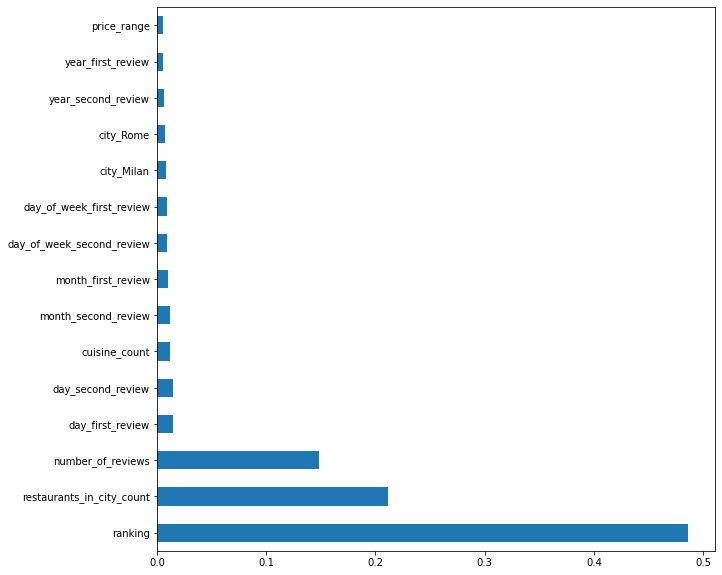

In [73]:
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=features_train.columns)
feat_importances.nlargest(15).plot(kind='barh');

Наиболее значимым признаком в модели оказался ranking, следом за ним идут количество уникальных ресторанов в городе и количество ревью. Остальные признаки имеют относительно невысокую значимость для модели.

Теперь для обучения модели используем всю обучающую выборку, протестируем её работу на тестовой выборке и отправим ответы на Kaggle.

Для начала проверим имеющиеся выборки.

In [74]:
test.head()

,ranking,price_range,number_of_reviews,cuisine_count,have_top_cuisine,net_or_unique,dates_of_reviews_count,review_timedelta,day_first_review,month_first_review,year_first_review,day_of_week_first_review,day_second_review,month_second_review,year_second_review,day_of_week_second_review,restaurants_in_city_count,city_Athens,city_Barcelona,city_Berlin,city_Bratislava,city_Brussels,city_Budapest,city_Copenhagen,city_Dublin,city_Edinburgh,city_Geneva,city_Hamburg,city_Helsinki,city_Krakow,city_Lisbon,city_Ljubljana,city_London,city_Luxembourg,city_Lyon,city_Madrid,city_Milan,city_Munich,city_Oporto,city_Oslo,city_Paris,city_Prague,city_Rome,city_Stockholm,city_Vienna,city_Warsaw,city_Zurich,ranking_bins
0,2.504102,2,-0.392351,2,0,1,0,0,1,1,2010,4,1,1,2010,4,5660,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,6
1,-0.962608,2,-0.069127,5,1,1,2,0,5,12,2017,1,29,10,2017,6,472,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,-0.772785,2,-0.308938,1,1,1,2,0,28,12,2017,3,6,12,2017,2,733,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,-0.541167,3,0.295803,5,1,1,2,0,6,12,2017,2,22,11,2017,2,6713,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,-0.981213,3,0.156782,6,1,1,2,0,8,2,2018,3,24,1,2018,2,378,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [75]:
train.head()

,ranking,price_range,number_of_reviews,rating,cuisine_count,have_top_cuisine,net_or_unique,dates_of_reviews_count,review_timedelta,day_first_review,month_first_review,year_first_review,day_of_week_first_review,day_second_review,month_second_review,year_second_review,day_of_week_second_review,restaurants_in_city_count,city_Athens,city_Barcelona,city_Berlin,city_Bratislava,city_Brussels,city_Budapest,city_Copenhagen,city_Dublin,city_Edinburgh,city_Geneva,city_Hamburg,city_Helsinki,city_Krakow,city_Lisbon,city_Ljubljana,city_London,city_Luxembourg,city_Lyon,city_Madrid,city_Milan,city_Munich,city_Oporto,city_Oslo,city_Paris,city_Prague,city_Rome,city_Stockholm,city_Vienna,city_Warsaw,city_Zurich,ranking_bins
10000,0.510683,2,0.267999,3.5,3,0,1,2,0,31,12,2017,6,20,11,2017,0,5660,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,3
10001,-0.576759,2,-0.371498,4.0,1,1,1,2,1,6,7,2017,3,19,6,2016,6,1009,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
10002,-0.896008,3,1.984909,4.5,7,1,1,2,0,8,1,2018,0,6,1,2018,5,6713,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10003,-0.058788,2,-0.395827,5.0,1,1,1,0,0,1,1,2010,4,1,1,2010,4,2582,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
10004,-0.823746,2,-0.114309,4.0,3,1,1,2,0,18,11,2017,5,19,2,2017,6,1127,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [76]:
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
5,id_5,4.5
6,id_6,4.5
7,id_7,2.0
8,id_8,2.0
9,id_9,3.5


Данные в порядке. Разделим тренировочную выборку на признаки для обучения и целевой признак.

In [77]:
features_train = train.drop('rating', axis=1)
target_train = train['rating']

Обучим модель.

In [78]:
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)
model.fit(features_train, target_train)
predictions = model.predict(test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.9s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished


Посмотрим на получившиеся предикты.

In [79]:
predictions

array([3.05 , 4.185, 4.635, ..., 3.   , 4.355, 4.365])

Заменим полученными предиктами значения рейтинга в наборе данных sample_submission.

In [80]:
sample_submission['Rating'] = predictions

Посмотрим, что получилось.

In [81]:
sample_submission.head()

,Restaurant_id,Rating
0,id_0,3.050
1,id_1,4.185
2,id_2,4.635
3,id_3,4.355
4,id_4,4.340


Выглядит как то, что нужно. Можно отправлять ответы на Kaggle.

In [82]:
sample_submission.to_csv('submission_1.csv', index=False)

# Вывод по этапу 6.

На данном этапе мы обучили модель и протестировали её работу с помощью метрики MAE: удалось достигнуть значения метрики в 0.2076 на валидационной выборке.

### <a href='#0'>К оглавлению.</a> 

# Итоговый вывод по проекту.

В рамках данного проекта требовалось предсказать рейтинг ресторана в TripAdvisor. Работу над проектом проводили по следующим этапам:

1. Импорт библиотек, подготовка функций, чтение и первичный анализ данных.

2. Предобработка данных.

3. Исследовательский анализ данных.

4. Создание новых признаков.

5. Препроцессинг.

6. Обучение и тестирование модели.

Метрикой качества модели была средняя квадратическая ошибка (МАЕ).

Отметим некоторые выводы по каждому этапу работы.

## Вывод по этапу 1.

На данном этапе мы испортировали необходимые для работы библиотеки, подготовили несколько функций для анализа и обработки данных, а также провели мини-EDA набора данных.

## Вывод по этапу 2.

На данном этапе мы осуществили предварительную обработку данных по следующим направлениям:

1. В признаке cuisine_style пропущенные значения заменили на наиболее часто встречающуюся в ресторанах кухню - Vegetarian Friendly.

2. В признаке price_range пропущенные значения заменили на наиболее часто встречающийся ценовой сегмент ресторана в наборе данных, а также закодировали категориальный признак в цифровое представление.

3. В признаке number_of_reviews пропущенные значения заменили на 0.

## Вывод по этапу 3.

На данном этапе мы провели исследовательский анализ данных некоторых имеющихся признаков.

Удалось выяснить, что:

1. В наборе данных встрачаются как одиночные рестораны, так и сети ресторанов.

2. Распределение признака Ranking сильно зависит от размера города и количества в нём ресторанов.

3. В разных городах имеется разное количество уникальных ресторанов.

4. В наборе данных больше всего информации об отзывах с оценкой от 3 и выше, а также с оценкой 0.

## Вывод по этапу 4.

На данном этапе мы создали новые признаки на основе уже имеющихся в наборе данных:

1. На основе признака "cuisine_style" мы создали признак, показывающий количество кухонь, представленных в ресторане, а также признак наличия в ресторане самой популярной кухни.

2. На основе признака "restaurant_id" мы создали признак, показывающий, чем является ресторан - уникальные заведением или сетью ресторанов.

3. На основе признака "reviews" мы создали два промежуточных параметра - дата первого и второго доступных ревью - и на их основе создали ряд новых признаков: разницу в днях между ревью, а также признаки-даты из этих двух дат: год, месяц, день и день недели первого и второго ревью.

4. С помощью признаков "city" и "restaurant_id" мы создали признак, описывающий количество уникальных ресторанов в каждом городе, а также дамми-переменные на основе признака "city", при этом для избежания эффекта мультиколлиреарности мы построили n-1 дамми-признак, где n - количество уникальных городов в наборе данных.

5. На основе признака "ranking" была создана переменная, разбивающая признак "ranking" на 10 групп по мере возрастания значения признака. Кроме того, признаки "ranking" и "number_of_reviews" были нормированы с помощью z-преобразования.

6. На последнем этапе мы избавились от ненужных для моделирования признаков, а также проверили признаки с помощью корреляционной матрицы на предмет сильной скоррелированности признаков с целеовой переменной и мультиколлинеарности.

## Вывод по этапу 5.

На данном этапе мы собрали весь пайплайн предобработки данных и создания новых признаков в единую функцию. Это позволит быстро готовить аналогичные данные к повторному моделированию.

## Вывод по этапу 6.

На данном этапе мы обучили модель и протестировали её работу с помощью метрики MAE: удалось достигнуть значения метрики в 0.2076 на валидационной выборке.

### <a href='#0'>К оглавлению.</a> 